In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from shapely import Polygon,Point,MultiPoint,LineString
from scipy.spatial import ConvexHull
from itertools import combinations
from shapely.ops import unary_union
from IPython.display import display, clear_output
from matplotlib import animation

In [7]:

    imp = .5
    X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2)])
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i][0][0] = X[i][0]-imp;
        Bx[i][0][1] = X[i][1]+imp;
        Bx[i][1][0] = X[i][0]+imp;
        Bx[i][1][1] = X[i][1]+imp;
        Bx[i][2][0] = X[i][0]+imp;
        Bx[i][2][1] = X[i][1]-imp;
        Bx[i][3][0] = X[i][0]-imp;
        Bx[i][3][1] = X[i][1]-imp;




In [77]:
print(X[1,0])

-2.0


In [2]:
def getPotRegions(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp, X[i][1]+imp]
        Bx[i,1,:]= [X[i][0]+imp, X[i][1]+imp]
        Bx[i,2,:]= [X[i][0]+imp, X[i][1]-imp]
        Bx[i,3,:]= [X[i][0]-imp, X[i][1]-imp]
    return(Bx);

In [3]:
def getPotRegions_var(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp[i], X[i][1]+imp[i]]
        Bx[i,1,:]= [X[i][0]+imp[i], X[i][1]+imp[i]]
        Bx[i,2,:]= [X[i][0]+imp[i], X[i][1]-imp[i]]
        Bx[i,3,:]= [X[i][0]-imp[i], X[i][1]-imp[i]]
    return(Bx);

In [2]:
def plothull(X):
    hull = ConvexHull(X);
    hullx = np.append(X[hull.vertices,0],X[hull.vertices[0],0]);
    hully = np.append(X[hull.vertices,1],X[hull.vertices[0],1]);
    plt.plot(hullx,hully);
    

In [4]:
def calcsafepoint(n,Bx):
    n = np.arange(n);
    comb3 = list(combinations(n,3));
    safeX = [];
    safeY =[];
    dp1 =[]
    for i in range(len(comb3)):
        comb2 = list(combinations(comb3[i][:],2))
        b1 = int(comb3[i][0]);
        b2 = int(comb3[i][1]);
        b3 = int(comb3[i][2]);
        dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
        idx = ConvexHull(dp1);
        dp1 = Polygon(dp1[idx.vertices,:]);
        dp2 = Polygon();
        for j in range(len(comb2)):
            a1 = comb2[j][0];
            a2 = comb2[j][1];
            temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
            idx = ConvexHull(temp);
            temp =  Polygon(temp[idx.vertices,:]);
            dp2 = unary_union([dp2,temp])
        diff = dp1.difference(dp2);
        x,y = np.array(diff.exterior.xy)
        safeX.append(x);
        safeY.append(y);
    return [safeX,safeY];

In [68]:
def CPIH_Safepoint(n,Bx):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);

    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
    CPIH= Polygon();
    #testing
   
    for C in combk:
        comb3 = list(combinations(C,3));
        dp1 =[];
        Chull = Polygon();
        for i in range(len(comb3)):
            comb2 = list(combinations(comb3[i][:],2))
            b1 = int(comb3[i][0]);
            b2 = int(comb3[i][1]);
            b3 = int(comb3[i][2]);
            dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
            idx = ConvexHull(dp1);
            dp1 = Polygon(dp1[idx.vertices,:]);
            dp2 = Polygon();
            for j in range(len(comb2)):
                a1 = comb2[j][0];
                a2 = comb2[j][1];
                temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
                idx = ConvexHull(temp);
                temp =  Polygon(temp[idx.vertices,:]);
                dp2 = unary_union([dp2,temp])
            diff = dp1.difference(dp2);
            Chull= unary_union([Chull,diff]);

            
        if (first and not Chull.is_empty):
            CPIH = Polygon(Chull.convex_hull);
          
        else:
            #NEW 
            if not Chull.is_empty:
                Chull = Polygon(Chull.convex_hull);
            #ENDNEW
            CPIH = CPIH.intersection(Chull);
            if not CPIH.geom_type == 'Polygon' and not CPIH.is_empty:
                
                for member in CPIH.geoms:
                    if member.geom_type == 'Polygon':
                        CPIH = member;
                       
            
            if CPIH.is_empty:
                return [0,0];
                break;
        first = False;
    safeX,safeY = np.array(CPIH.exterior.xy)
        #safeX.append(x);
        #safeY.append(y);
    return [safeX,safeY];
    #return CPIH

In [5]:
def maintDist(X,agent,imp):
    delta = 2.155*2*imp;
    dx = 0;
    for i in range(len(X)):
        if agent != i and i != len(X)-1:
            norm = np.linalg.norm(X[i]-X[agent]);
            dx+=  ((norm-delta)/norm)*(X[i]-X[agent]);
    return np.array(dx);

In [6]:
def maxDist(Xi,safeX,safeY):
    max_dist = 0;
    max_indx = [];
    for i in range(len(safeX)):
        norm = np.linalg.norm(Xi-[safeX[i],safeY[i]]);
        if norm> max_dist:
            max_dist = norm;
            max_indx = i;
    return [safeX[max_indx],safeY[max_indx]],max_dist;

In [7]:
def meansafepoint(safeX,safeY):
    mx =0;
    my = 0;
    count = 0;
    for i in range(len(safeX)):
        if (len(safeX[i]) != 0):
            mx += np.mean(safeX[i]);
            my += np.mean(safeY[i]);
            count+=1;
    mx = mx/count;
    my = my/count;
    return mx,my;



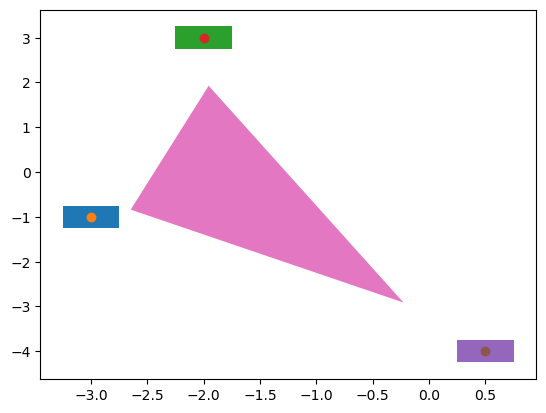

In [29]:
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4)]);
imp = .25;
Bx = getPotRegions(X,imp);
safeX,safeY= calcsafepoint(3,Bx);
fig, ax = plt.subplots();
for i in range(3):
    xb = Bx[i][:,0];
    yb = Bx[i][:,1];
    ax.fill(xb,yb);
    x = X[i][0];
    y = X[i][1];
    ax.scatter(x,y);
ax.fill(safeX[0],safeY[0])

In [22]:
def getAllHulls(X,n,imp1,imp2):
        safepoints = [];
        x = X[n];
        X[n] = x+[imp1,0];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);
        X[n] = x+[-imp1,0];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);
        X[n] = x+[0, imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[0,-imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[imp1,imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[imp1,-imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[-imp1,imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);        
        X[n] = x+[-imp1,-imp1];
        Bx = getPotRegions(X,imp2);
        safeX,safeY= calcsafepoint(3,Bx);
        safepoints.append([np.mean(safeX[0]),np.mean(safeY[0])]);
        X[n] = x;
        return safepoints;
    

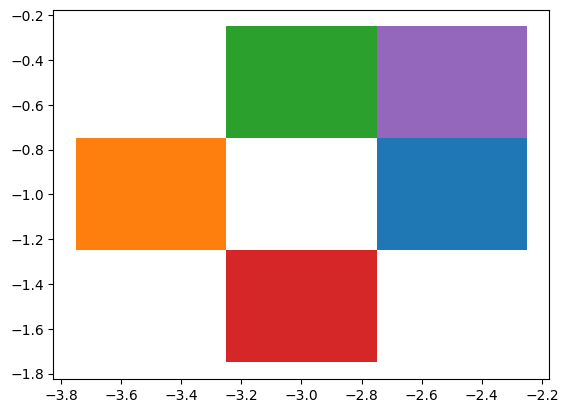

In [10]:
ball = getAllHulls(X[0],.5,.25);
fig, ax = plt.subplots();
for i in range(5):
    xb = ball[i][0][:,0];
    yb = ball[i][0][:,1];
    ax.fill(xb,yb);
    


In [51]:
Xall = [[],[],[]];
for i in range(3):
    for m in range(-1,2):
        temp = X[i]+[m*2*imp,0];
        print(temp);
        for n in range(-1,2):
            temp2 = temp+[0,n*2*imp];
            print(temp2,' temp2');
            Xall[i].append(temp2);


[-4. -1.]
[-4.  -1.5]  temp2
[-4. -1.]  temp2
[-4.  -0.5]  temp2
[-3.5 -1. ]
[-3.5 -1.5]  temp2
[-3.5 -1. ]  temp2
[-3.5 -0.5]  temp2
[-3. -1.]
[-3.  -1.5]  temp2
[-3. -1.]  temp2
[-3.  -0.5]  temp2
[-2.5  3. ]
[-2.5  2.5]  temp2
[-2.5  3. ]  temp2
[-2.5  3.5]  temp2
[-2.  3.]
[-2.   2.5]  temp2
[-2.  3.]  temp2
[-2.   3.5]  temp2
[-1.5  3. ]
[-1.5  2.5]  temp2
[-1.5  3. ]  temp2
[-1.5  3.5]  temp2
[ 0. -4.]
[ 0.  -4.5]  temp2
[ 0. -4.]  temp2
[ 0.  -3.5]  temp2
[ 0.5 -4. ]
[ 0.5 -4.5]  temp2
[ 0.5 -4. ]  temp2
[ 0.5 -3.5]  temp2
[ 1. -4.]
[ 1.  -4.5]  temp2
[ 1. -4.]  temp2
[ 1.  -3.5]  temp2


In [64]:
Bx = getPotRegions(X,imp2);
safeX,safeY = calcsafepoint(3,Bx);
safe = [np.mean(safeX),np.mean(safeY)];
print(safe)

[-1.8963414634146343, -0.14024390243902435]


In [65]:
dist = [];
for point in safepoints:
    p = np.array(point);
    dist.append(np.sqrt(np.dot(p-safe,p-safe)));
    
print(dist);

[0.7071067811865476, 0.6286309039379262, 0.552208829699534, 0.59249053262459, 0.5086207451877202, 0.4273782845577752, 0.49129589651001454, 0.401023748639361, 0.31287384905157684, 0.5816637738363826, 0.5164096025404598, 0.4609606800040052, 0.45334302655945835, 0.38521585984740236, 0.3322068676359618, 0.33494616036474023, 0.26161779366704824, 0.21215358580179616, 0.48963053950629354, 0.4512352716750039, 0.43303664254624485, 0.3573675958877609, 0.3290118694393938, 0.33221773145445305, 0.2331937957642883, 0.22346657504612455, 0.2611297913344972, 0.5613822357594512, 0.4668899767950281, 0.3707096431174907, 0.47463200620559237, 0.3743922300733842, 0.2707682827356129, 0.41751585769522875, 0.3174587535917143, 0.2162672603078337, 0.4002511492651862, 0.3125421043236482, 0.23223952136839526, 0.29427398809229477, 0.19491992675550293, 0.09898897169962974, 0.2284129696042473, 0.12878161830344984, 0.05139274271580659, 0.26447754167990656, 0.20906921887448, 0.19546041105969605, 0.12929393787635543, 0.0

In [66]:
print(max(dist));

0.7071067811865476


# CONSTANT IMPRECISION SIMULATION

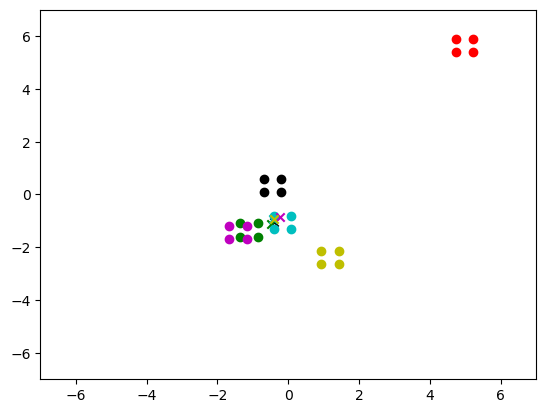

In [75]:
plt.ion();
fig, ax = plt.subplots()
#X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2),(4,-1)]);
offset = np.ones((6,2))*.5;
X= 12*(np.random.rand(6,2)-offset)
Xsave = X;
Xn = np.zeros((6,6,2));
Xn[:]= X;
n = len(X);
imp = .25;
colors= ['k','g','c','m','y','r'];
empty = False;
frames = [];
step = 0;
emptyCPIH = np.zeros((n,1));
target = np.zeros((n,2));
targetlast = np.zeros((n,2));
targetdist=np.zeros((n,1));
ims = [];
lastCPIH = [[],[],[],[],[]];
temp = [];
while not empty:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        Xn[i] = X+2*.25*(np.random.rand(6,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions(Xn[i],imp);

        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint(n,Bx);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                emptyCPIH[i] = 1;
                target[i] = targetlast[i]
            else:
                targetlast[i] = [np.mean(safeX),np.mean(safeY)]; 
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                lastCPIH[i] = [safeX,safeY];
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
        
    for i in range(n):
        X[i]= X[i]+dt*(target[i]-X[i])/(np.linalg.norm(X[i]-target[i]))*max((np.linalg.norm(X[i]-target[i])),1);
        if i<n-1:
            dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    if dist< (n-1)*imp*.5 or not any(emptyCPIH[0:4] == 0):
        empty = True;
    artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    
    for j in range(n):
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            #ax.scatter(x,y)
            artist.append(ax.scatter(x,y,c= colors[j]));
            if emptyCPIH[j] == 1:
                artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))
    frames.append(artist);
    clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    plt.pause(0.1)
    step +=1;
    
#ax.scatter(minimalhull[0],minimalhull[1]);


ani = animation.ArtistAnimation(fig= fig,artists = frames,interval = 50, blit = True);
ani.save('CPIH_rand_pos_t2.gif');
display(fig);

-0.399548758969051
-1.0603007228541987
-0.4304018816646789
-0.38467428269937715
-0.40188938947915154


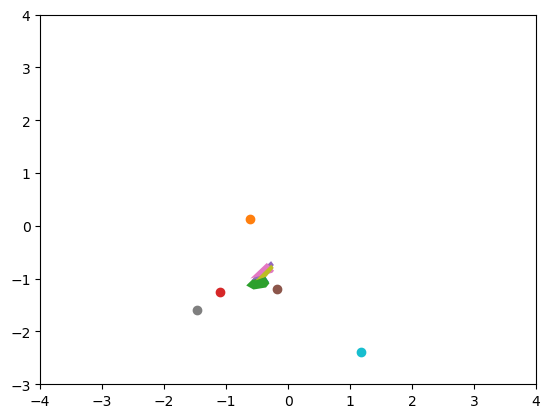

In [79]:
print(np.mean(lastCPIH[0][0]))
print(np.mean(lastCPIH[0][1]))
print(np.mean(lastCPIH[2][0]))
print(np.mean(lastCPIH[3][0]))
print(np.mean(lastCPIH[4][0]))
fig, ax = plt.subplots();
ax.cla();
ax.set_xlim(-4,4);
ax.set_ylim(-3,4);
for i in range(5):
    x = lastCPIH[i][0];
    y = lastCPIH[i][1];
    ax.fill(x,y)
    xn = X[i][0];
    yn = X[i][1];
    ax.scatter(xn,yn);
    
    


In [77]:
avgdist = 0;
maxdist = 0;

for i in range(n-2):
    for j in range(i+1,n-1):
        dij = np.sqrt(np.dot((target[j]-target[i]),(target[j]-target[i])));
        avgdist += dij;
        maxdist = max(dij,maxdist);
        
avgdist = avgdist/10;

print('avg dist=',(avgdist));
print('max dist = ',(maxdist));

avg dist= 0.18677700201643507
max dist =  0.3738157153609584


In [78]:
print(Xsave)

[[-0.60950122  0.13841629]
 [-1.09348046 -1.25196449]
 [-0.17616328 -1.19920108]
 [-1.47875527 -1.59056354]
 [ 1.16821583 -2.38663421]
 [ 4.89988826  5.53326474]]


# VARIABLE IMPRECISION SIMULATION

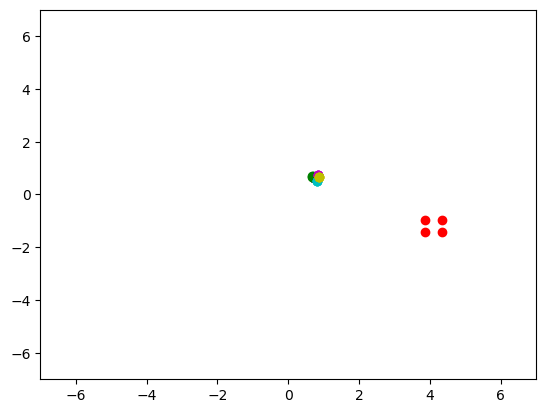

In [32]:
plt.ion();
fig, ax = plt.subplots()
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2),(4,-1)]);
Xn = np.zeros((6,6,2));
Xn[:]= X;
n = len(X);
imp = .5*np.ones((6,6))-.5*np.eye(6);
colors= ['k','g','c','m','y','r'];
empty = False;

frames = [];
step = 0;
emptyCPIH = np.zeros((6,1));
hist = [];
for i in range(5):
    hist.append([]);
B2hist = []
target = np.zeros((n,2));
targetdist=np.zeros((n,1));
ims = [];
while not empty:
    im = [];
    #ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dt = .01;
    n = len(X);
    
    safeX= [];
    safeY=[];
    dist = 0;
    for i in range(n):
        for j in range(n):
                imp[i][j] = np.linalg.norm(X[i]-X[j])/15;
                Xn[i][j] = X[j]+2*imp[i][j]*(np.random.rand(1,2)-.5);
        Xn[i][i]  = X[i];
        if i!= n-1:
            Bx = getPotRegions_var(Xn[i],imp[i][:]);

        #if i != n-1 and emptyCPIH[i] == 0:
        if i != n-1:
            safeX,safeY = CPIH_Safepoint(n,Bx);
            #CPIH = CPIH_Safepoint(n,Bx);
            #safeX,safeY = optConfig(Xn[i],i,imp);
            if (isinstance(safeX,int) and isinstance(safeY,int)):
                #print('CPIH empty');
                #empty = True;
                hist[i].append(-step);
                emptyCPIH[i] = 1;
                if i == 2:
                    B2hist.append(Bx);
                target[i]= X[i];
            else:
                #target[i] = [np.mean(safeX),np.mean(safeY)];
                target[i],targetdist[i] = maxDist(X[i],safeX,safeY);
                if emptyCPIH[i]:
                    hist[i].append(step);
                    emptyCPIH[i] = 0;
                    
               # emptyCPIH[i] =1;
            
        elif i== n-1:
            target[i] = np.array([(6,6)])
        
    for i in range(n-1):
        X[i]= X[i]+dt*targetdist[i]*(target[i]-X[i]);
        dist += np.sqrt(np.dot((target[i]-X[i]),(target[i]-X[i])));
        #X[i]= X[i]+dt*(target[i]);
    if step>499 or any(emptyCPIH == 1):
        empty = True;
    artist = ax.fill(safeX,safeY,'b',alpha = 0.3);
    
    for j in range(n):
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            #ax.scatter(x,y)
            artist.append(ax.scatter(x,y,c= colors[j]));
            if emptyCPIH[j] == 1:
                artist.append(ax.scatter(target[j][0],target[j][1], c = colors[j],marker = 'x'))
    frames.append(artist);
    clear_output(wait = True);
   # fig.canvas.draw()
    #fig.canvas.flush_events();
    #display(fig);
    
    plt.pause(0.1)
    step +=1;
    
#ax.scatter(minimalhull[0],minimalhull[1]);


ani = animation.ArtistAnimation(fig= fig,artists = frames,interval = 50, blit = True);
ani.save('CPIH.gif');
display(fig);

# Live Simulation

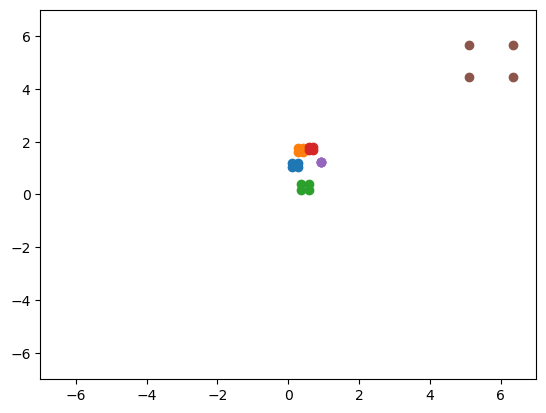

In [13]:
plt.ion();
fig, ax = plt.subplots();
X = np.array([(-3,-1), (-2, 3),(0.5 ,-4),(1.5,6),(3.2,2),(4,-1)]);
Xn = np.zeros((6,6,2));
Xn[:]= X;
imp = .5*np.ones((6,6))-.5*np.eye(6);

#plt.ion();
plot1 = [];
plot2 = [];

for t in range(200):
    ax.cla();
    ax.set_xlim(-7,7);
    ax.set_ylim(-7,7);
    dx = .01;
    n = len(X);
    target = np.zeros((n,2));
    for i in range(n):
        if i != n-1:
            for j in range(n):
                imp[i][j] = np.linalg.norm(X[i]-X[j])/10;
            #Xn[i] = X+2*imp*(np.random.rand(6,2)-.5);
            Bx = getPotRegions_var(X,imp[i][:]);
            safeX,safeY = CPIH_Safepoint(n,Bx);
            target[i] = [np.mean(safeX),np.mean(safeY)]; 
            
        else:
            target[i] = np.array([(6,6)])
        
    for i in range(n):
        X[i]= X[i]+dx*(target[i]-X[i]);
        

    #ax,plot1,plot2 = plotagents(fig,Bx,safeX,safeY,ax,t,plot1,plot2);
    
   # for i in range(len(safeX)):
    #        x = safeX[i][:];
     #       y = safeY[i][:];
      #      ax.fill(x,y);
    for j in range(n):
            x = Bx[j,:,0];
            y = Bx[j,:,1];
            ax.scatter(x,y);
    fig.canvas.draw()
    fig.canvas.flush_events();
    display(fig);
    clear_output(wait = True);
    plt.pause(0.1)

    

In [13]:
hist = [];
for i in range(5):
    hist.append([]);
hist[1].append(3);
hist[1].append(4);
print(hist)
    

[[], [3, 4], [], [], []]


In [24]:
print(emptyCPIH)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [36]:
print(hist[4][:])

[]


In [14]:
print(B2hist[0][:])

IndexError: list index out of range

IndexError: list index out of range

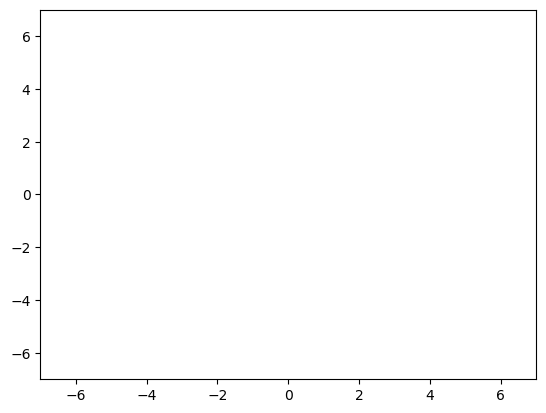

In [15]:
fig, ax = plt.subplots();
ax.cla();
ax.set_xlim(-7,7);
ax.set_ylim(-7,7);
for i in range(len(B2hist[0][:])):
    x = B2hist[0][i][:,0];
    y = B2hist[0][i][:,1];
    ax.scatter(x,y)
sx,sy = CPIH_Safepoint(n,B2hist[0][:]);
ax.fill(sx,sy)
#       y = safeY[i][:];
      #      ax.fill(x,y);

In [30]:
sx,sy = CPIH_Safepoint(n,B2hist[0][:]);

In [30]:
print(dist/5)

0.2690806449515544


In [31]:
print(step)

501
